# Sentiment Analysis on Amazon Reviews dataset 2023

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from Huggingface
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [3]:
# Read in data
Appliance_subset_df = pd.read_parquet('..\Project Main\data\Appliance_file_subset.parquet', engine='pyarrow')

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

regex = re.compile("[^a-zA-Z ]")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gisi_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gisi_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = regex.sub(' ', text) # Substitute everything that is not a letter with an empty string
    words = word_tokenize(text) # tokenize text
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words

# Apply the preprocessing function to your text column
Appliance_subset_df['text_clean'] = Appliance_subset_df['text'].apply(preprocess_text)

In [11]:
Appliance_subset_df.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,text_clean
0,2.0,"Maybe they be ok for you, but",It was difficult for this old guy to get down ...,[],B074FP8GC5,B0BWXQJ5XT,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,1619039933066,0,True,"[difficult, old, guy, get, install, daughters,..."
1,5.0,Five Stars,Great!,[],B0000CF3HB,B0000CF3HB,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,1485195813000,0,True,[great]
2,5.0,Saves a lot on the cost of coffee.,Works very well. They also clean very easily.,[],B01AUBYMK2,B07RNJY499,AGIOHNK7IWRDNBWYPGETIDTKTJUA,1505914496902,0,True,"[works, well, also, clean, easily]"
3,5.0,Works great,Easy to use. Easy to remove. Works as it sho...,[],B079ZJ1H3P,B06XXPGQQV,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,1605903535168,0,True,"[easy, use, easy, remove, works]"
4,5.0,Humidifier Filters,As described great shape thank you,[],B000E1385Y,B000E1385Y,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,1645229528359,0,True,"[described, great, shape, thank]"


In [12]:
print(Appliance_subset_df.shape)

(50000, 11)


In [13]:
Appliance_subset_df['rating'].value_counts().sort_index()

rating
1.0     5918
2.0     1871
3.0     2421
4.0     5024
5.0    34766
Name: count, dtype: int64

## Quick EDA

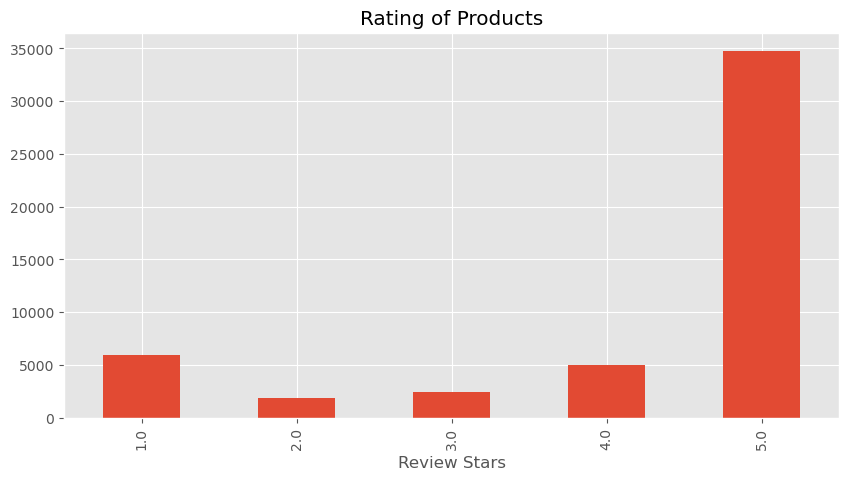

In [14]:
rating = Appliance_subset_df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Rating of Products',
          figsize=(10, 5))
rating.set_xlabel('Review Stars')
plt.show()

## NLTK

In [15]:
example = Appliance_subset_df['text_clean'][1989]
print(example)

['easy', 'replacement', 'parts', 'appliances', 'reduced', 'price', 'fits', 'perfect']


# Step 1. VADER Sentiment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [19]:
sia

In [20]:
sia.polarity_scores("It was a complete waste of time")

{'neg': 0.359, 'neu': 0.641, 'pos': 0.0, 'compound': -0.4215}

In [21]:
sia.polarity_scores(example)

AttributeError: 'list' object has no attribute 'encode'

In [15]:
sia.polarity_scores("Fits perfect")

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [16]:
sia.polarity_scores('Easy Replacement Parts for Appliances at a Reduced Price and fits perfect')

{'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'compound': 0.765}

In [17]:
sia.polarity_scores('Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...')

{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

interesting

Should be more positive than that

In [18]:
# Run the polarity score on the entire dataset
results = {}
for i, row in tqdm(Appliance_subset_df.iterrows(), total=len(Appliance_subset_df)):
    opinion = row['text']
    id = row['user_id']
    results[id] = sia.polarity_scores(opinion)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [19]:
results

{'AFJBSFUSBCMWLLXMBZ44ETHRKNOA': {'neg': 0.072,
  'neu': 0.809,
  'pos': 0.118,
  'compound': 0.3818},
 'AGB653QU2TLQPUZ2QX3VNRWFOUKQ': {'neg': 0.0,
  'neu': 0.0,
  'pos': 1.0,
  'compound': 0.6588},
 'AGIOHNK7IWRDNBWYPGETIDTKTJUA': {'neg': 0.0,
  'neu': 0.391,
  'pos': 0.609,
  'compound': 0.7774},
 'AGBTZVKIXMEBARPSYPIQLFH2NYWQ': {'neg': 0.0,
  'neu': 0.58,
  'pos': 0.42,
  'compound': 0.7003},
 'AHKS2IQWTIFWQZTUVP23U2GYLO5Q': {'neg': 0.0,
  'neu': 0.377,
  'pos': 0.623,
  'compound': 0.765},
 'AHY557OHZXZUGKRAB6ZHRONRE26A': {'neg': 0.0,
  'neu': 0.671,
  'pos': 0.329,
  'compound': 0.6597},
 'AGOICXX54S3SREXAOM3BYYN4AZRA': {'neg': 0.082,
  'neu': 0.918,
  'pos': 0.0,
  'compound': -0.395},
 'AHO74DWEGRT3UVGRKG4CCOMTL5BA': {'neg': 0.0,
  'neu': 0.734,
  'pos': 0.266,
  'compound': 0.4404},
 'AH7AGJZSWT5KAEW4OFJIH5DQCUUA': {'neg': 0.042,
  'neu': 0.863,
  'pos': 0.096,
  'compound': 0.9699},
 'AFMZ3YXI2VANHHEXF2LCBCYHFEGA': {'neg': 0.043,
  'neu': 0.803,
  'pos': 0.154,
  'compound': 

In [20]:
vaders = pd.DataFrame(results).T
vaders.head()

,neg,neu,pos,compound
AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [22]:
vaders.index.name = 'user_id'
vaders.head()

,neg,neu,pos,compound
user_id,,,,
AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [23]:
# Reset the index to turn the index into a column
vaders = vaders.reset_index()
vaders.head()


,user_id,neg,neu,pos,compound
0,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
1,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
2,AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
3,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
4,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [24]:
vaders = vaders.merge(Appliance_subset_df, how='inner')

In [25]:
# Now we have sentiment score and metadata
vaders.head()

,user_id,neg,neu,pos,compound,rating,title,text,images,asin,parent_asin,timestamp,helpful_vote,verified_purchase
0,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818,2.0,"Maybe they be ok for you, but",It was difficult for this old guy to get down ...,[],B074FP8GC5,B0BWXQJ5XT,1619039933066,0,True
1,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588,5.0,Five Stars,Great!,[],B0000CF3HB,B0000CF3HB,1485195813000,0,True
2,AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774,5.0,Saves a lot on the cost of coffee.,Works very well. They also clean very easily.,[],B01AUBYMK2,B07RNJY499,1505914496902,0,True
3,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003,5.0,Works great,Easy to use. Easy to remove. Works as it sho...,[],B079ZJ1H3P,B06XXPGQQV,1605903535168,0,True
4,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650,5.0,Humidifier Filters,As described great shape thank you,[],B000E1385Y,B000E1385Y,1645229528359,0,True


## Plot VADER results

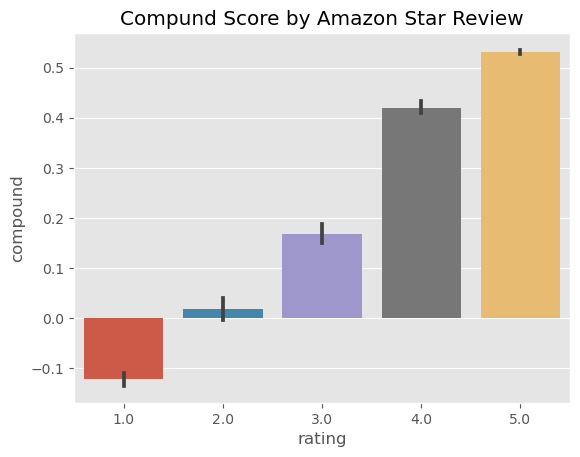

In [27]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

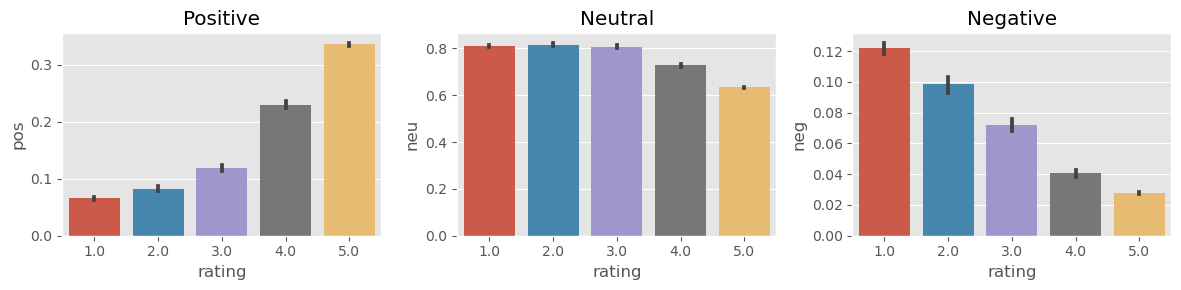

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

next step Install PyTorch

In [30]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [31]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

c:\Users\gisi_\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gisi_\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

c:\Users\gisi_\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModelForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(example)

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

In [22]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

In [24]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [ ]:
results_df.columns

# Step 3. Combine and compare

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

In [29]:
# nevative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline('I love sentiment analysis!')

In [ ]:
sent_pipeline('Make sure to like and subscribe!')

In [ ]:
sent_pipeline('booo')

# __